# Test After Training Data Cutoff: `2024-01-01 17:30 UTC`

Evaluate model in production with never before seen data (after training data cut-off)

Test model performance with a range of probability thresholds from 50% to 95% to learn:
- Best threshold to use for optimal returns
- Model performance on real data
- Strategy for trading with just a `binary` inference model (BUY or SELL)

### 2024-02-29:
So far, model performance on BTCUSD indicates positive returns with minimal drawdowns. Also, findings indicate that the binary model can serve as both a buy and hold signal. Consequtive BUY signals are currently treated as simply BUY(1)+HOLD(N). First SELL signal indicates when to exit position.


In [1]:
from utils import process_ticks, compute_latest_stats, generate_timesteps_from_ticks, predict_via_serving
from utils import date_range, interval_infill, get_observation_v2, column_normalize, group_normalize, round_threshold

from db import DBManager, Asset, Tick, Timestep, ENVIRONMENT, MANAGER_ERROR
from hyperparameters import Params

from datetime import datetime, timedelta, timezone
from typing import List, Tuple, Any

model_endpoint = "http://192.168.50.61:8501/v1/models/model:predict"
acceptable_response_codes = [200]

params: Params = Params()
manager: DBManager = DBManager(environment=ENVIRONMENT.PREPROD)
params

Params(
	max_holding_period: 1,
	max_look_back_period: 18, 
	volatility_period: 7 
	min_expected_return: 0.03, 
	max_trailing_loss: 0.1 
	smas: {'s14': 672, 's50': 2400, 's100': 4800, 's350': 16800, 's700': 33600} 
	target_fields: ['c', 's50', 's100', 's350', 's700', 'v', 'hv'] 
	observation_shape: (24, 36, 7),
	interval: 30
	holding_period_in_T: 48,
	look_back_period_in_T: 864,
	volatility_period_in_T: 336,
)

In [2]:
start_date = datetime(2024, 1, 1, 17, 30, tzinfo=timezone.utc)
start_date = datetime(2021, 1, 1, 17, 30, tzinfo=timezone.utc)

inference_frame_start_date = start_date - timedelta(days=18)
increment = timedelta(minutes=30)

max_timesteps = 5000
max_timesteps = 60000
msg, timesteps = manager.get_historical_timesteps(start=inference_frame_start_date, frame_length=max_timesteps, asset=Asset.btcusd)
timesteps.head(5)

,asset,c,v,hv,s14,s50,s100,s350,s700,delta
date,,,,,,,,,,
2020-12-14 17:30:00+00:00,Asset.btcusd,19151.000000,6.062215,459.512556,18885.387210,16777.342810,13899.565712,10422.876263,8980.945135,-0.000209
2020-12-14 18:00:00+00:00,Asset.btcusd,19209.642122,46.237909,460.142103,18885.342035,16779.936047,13901.457304,10423.586766,8981.404708,0.003062
2020-12-14 18:30:00+00:00,Asset.btcusd,19237.989931,23.252005,461.000045,18885.416425,16782.535626,13903.340427,10424.299018,8981.865208,0.001476
2020-12-14 19:00:00+00:00,Asset.btcusd,19230.000000,15.534332,461.658722,18885.297377,16785.123259,13905.275635,10425.011583,8982.325466,-0.000415
2020-12-14 19:30:00+00:00,Asset.btcusd,19187.901761,19.994554,462.287672,18885.172231,16787.681135,13907.191344,10425.721726,8982.784362,-0.002189


In [3]:
print(f"#Timesteps: {len(timesteps):,.0f}, #Inference intervals: {len(timesteps) - params.observation_size:,.0f}")
timesteps.tail(5)

#Timesteps: 56,452, #Inference intervals: 55,588


,asset,c,v,hv,s14,s50,s100,s350,s700,delta
date,,,,,,,,,,
2024-03-04 17:00:00+00:00,Asset.btcusd,66631.0,7.912306,2826.378331,56135.665179,47786.735880,45139.281856,33661.057486,28486.676846,0.000571
2024-03-04 17:30:00+00:00,Asset.btcusd,66863.0,134.257184,2817.149789,56157.675595,47796.687685,45145.342481,33663.392724,28487.316549,0.003482
2024-03-04 18:00:00+00:00,Asset.btcusd,66936.0,2.856271,2808.229649,56179.866071,47806.708935,45151.416856,33665.719926,28487.961668,0.001092
2024-03-04 18:30:00+00:00,Asset.btcusd,66636.0,41.117742,2797.156169,56201.799107,47816.598241,45157.419148,33668.020283,28488.590150,-0.004482
2024-03-04 19:00:00+00:00,Asset.btcusd,66598.0,0.080961,2789.639310,56223.833333,47826.527407,45163.416932,33670.333081,28489.210620,-0.000570


## Inference

Loop over frames starting at `start_date` in `increments`

Execute inference on each frame

Record Trade and estimated profitability


In [4]:
import json
import requests
import numpy as np
import logging

def classify_future(
    future_deltas
    , max_trailing_loss
    , min_expected_return
):
    trailing_loss = 0.0
    pnl = 0.0
    future_profiltable = False
    stopped_out = False
    trade_duration = 0
    for delta in future_deltas:
        trade_duration += 1
        if trade_duration == 1:
            pnl = 1 + delta
            trailing_loss = delta
        else:
            new_pnl = pnl * (1 + delta)
            trailing_loss = trailing_loss + (new_pnl - pnl)
            pnl = new_pnl
        if trailing_loss >= 0.0:
            trailing_loss = 0.0
        if abs(trailing_loss) >= abs(max_trailing_loss):
            # Failed trade, sell position, stop trade
            stopped_out = True
            break
    pnl = pnl - 1
    future_profitable = pnl >= min_expected_return
    return future_profitable, trade_duration, pnl, trailing_loss

def classify_future_new(
    future_deltas
    , max_trailing_loss=0.10
    , min_expected_return=0.03
):
    trailing_loss = 0.0
    pnl = 0.0
    future_profiltable = False
    stopped_out = False
    initial_value = 1
    current_value = 1
    prev_value = current_value
    max_drawdown = 0
    trade_duration = 0
    for delta in future_deltas:
        trade_duration += 1
        #pnl = (1 + pnl) * (1 + delta) - 1
        prev_value = current_value
        current_value = current_value * (1 + delta)
        tick_diff = current_value - prev_value
        if tick_diff < 0:
            # compound trailing losses
            trailing_loss = (1 + trailing_loss) * (1 + tick_diff/prev_value) - 1
            if trailing_loss < max_drawdown:
                max_drawdown = trailing_loss
        else:
            # Restart trailing losses
            trailing_loss = 0
        if abs(trailing_loss) >= abs(max_trailing_loss):
            # Failed trade, sell position, stop trade
            stopped_out = True
            break
        #print(f"Delta: {delta:5.3f}, Loss: {trailing_loss:5.3f}, Drawdown: {max_drawdown:5.3f} Current: {current_value:5.3f}")
    pnl = (current_value - initial_value)/initial_value
    future_profitable = pnl >= min_expected_return
    return future_profitable, trade_duration, pnl, abs(max_drawdown)


### Load Saved Data

In [5]:
import pandas as pd

df = pd.read_pickle('./trade-simulation-20210101_20240229.p')
df.head()


,probability,profitable,duration,pnl,drawdown,action_40,correct_40,action_42,correct_42,action_45,...,action_85,correct_85,action_87,correct_87,action_90,correct_90,action_92,correct_92,action_95,correct_95
start,,,,,,,,,,,,,,,,,,,,,
2021-01-01 17:00:00+00:00,0.836510,True,48,0.111900,0.0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2021-01-01 17:30:00+00:00,0.829121,True,48,0.127452,0.0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2021-01-01 18:00:00+00:00,0.775835,True,48,0.126028,0.0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2021-01-01 18:30:00+00:00,0.701667,True,48,0.132578,0.0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2021-01-01 19:00:00+00:00,0.724876,True,48,0.134071,0.0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


### Timestep Delta Metrics

In [6]:
dmean = timesteps.delta.mean()
dmedian = timesteps.delta.median()
dstd = timesteps.delta.std()
print(f"Mean: {dmean:7.3f}, Median: {dmedian:7.3f}, Standard Deviation: {dstd:7.3f}")

dthreshold_66 = dmean + dstd 
over_66 = timesteps.delta[timesteps.delta > dthreshold_66]
print(f"Above 66th percentile:\n\t Count: {len(over_66):7}, Mean: {over_66.mean():7.3f}, Median: {over_66.median():7.3f}")

dthreshold_95 = dmean + 2*dstd 
over_95 = timesteps.delta[timesteps.delta > dthreshold_95]
print(f"Above 95th percentile:\n\t Count: {len(over_95):7}, Mean: {over_95.mean():7.3f}, Median: {over_95.median():7.3f}")


Mean:   0.000, Median:   0.000, Standard Deviation:   0.005
Above 66th percentile:
	 Count:    4774, Mean:   0.010, Median:   0.008
Above 95th percentile:
	 Count:    1410, Mean:   0.016, Median:   0.014


### Inference Loop

In [7]:
RUN_INFERENCE: bool = False
SAVE_RESULTS: bool = False

In [8]:

import pandas as pd

if RUN_INFERENCE:
    count = len(timesteps) - params.observation_size - 48
    
    #model_endpoint = "http://192.168.50.61:8501/v1/models/model:predict"
    max_trailing_loss: float   = 0.10
    min_expected_return: float = 0.03
    
    start = 0
    observation = None
    
    trades: List[dict] = []
    
    for idx in range(count):
        if not(idx % 100):
            print(idx, end='')
        else:
            print('.', end='')
            
        start = idx
        end   = start + params.observation_size
        hold_end = end + params.holding_period_in_T
        frame = timesteps[start:end]
        holding = timesteps[end:hold_end]
        observation = get_observation_v2(frame)
        start_date = frame.index[-1].to_pydatetime()
        prediction = predict_via_serving(observation, endpoint=model_endpoint)
        
        future_deltas = holding['delta'].to_numpy()
        
        profitable, duration, pnl, drawdown = classify_future_new(
            future_deltas
            , max_trailing_loss
            , min_expected_return
        )
        
        trades.append({
            'start': start_date
            , 'profitable':profitable
            , 'duration': duration
            , 'pnl': pnl
            , 'drawdown': drawdown
            , 'prediction': prediction
        })
    
    df = pd.DataFrame(trades)
    df.reset_index(drop=True, inplace=True)
    df.set_index('start', inplace=True)
    df.sort_index(inplace=True)
    
    # Generate accuracy measures
    thresholds = [40,42,45,50,52,55,57,60,62,65,67,70,72,75,77,80,82,85,87,90,92,95]
    for t in thresholds:
        df[f'action_{t}'] = df.apply(lambda s: round_threshold(s.probability, threshold=t/100), axis=1)
        df[f'correct_{t}'] = df.apply(lambda s: 1 if round_threshold(s.probability, threshold=t/100)==1 and s.profitable else 0, axis=1)
    if SAVE_RESULTS:
        df.to_pickle('./trade-simulation-20210101_20240229.p')
    df.head()


### Apply new `classify_future` function

In [9]:
if not RUN_INFERENCE:
    max_trailing_loss: float   = 0.10
    min_expected_return: float = 0.03
    start = 0
    observation = None
    count = len(timesteps) - params.observation_size - 48
    trades: List[dict] = []
    
    for idx in range(count):
        if not(idx % 500):
            print(idx, end='')
        else:
            print('.', end='')
            
        start = idx
        end   = start + params.observation_size
        hold_end = end + params.holding_period_in_T
        frame = timesteps[start:end]
        holding = timesteps[end:hold_end]    
        start_date = frame.index[-1].to_pydatetime()
        future_deltas = holding['delta'].to_numpy()
        
        profitable, duration, pnl, drawdown = classify_future_new(
            future_deltas
            , max_trailing_loss
            , min_expected_return
        )
        timestep_idx = frame.index[-1]
        df.loc[timestep_idx, 'profitable'] = profitable
        df.loc[timestep_idx, 'duration'] = duration
        df.loc[timestep_idx, 'pnl'] = pnl
        df.loc[timestep_idx, 'drawdown'] = drawdown

df.head()


0...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................500.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

,probability,profitable,duration,pnl,drawdown,action_40,correct_40,action_42,correct_42,action_45,...,action_85,correct_85,action_87,correct_87,action_90,correct_90,action_92,correct_92,action_95,correct_95
start,,,,,,,,,,,,,,,,,,,,,
2021-01-01 17:00:00+00:00,0.836510,True,48.0,0.111900,0.014051,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 17:30:00+00:00,0.829121,True,48.0,0.127452,0.014051,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 18:00:00+00:00,0.775835,True,48.0,0.126028,0.014051,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 18:30:00+00:00,0.701667,True,48.0,0.132578,0.014051,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 19:00:00+00:00,0.724876,True,48.0,0.134071,0.014051,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
if not RUN_INFERENCE:
    # Generate accuracy measures
    thresholds = [40,42,45,50,52,55,57,60,62,65,67,70,72,75,77,80,82,85,87,90,92,95]
    for t in thresholds:
        df[f'action_{t}'] = df.apply(lambda s: round_threshold(s.probability, threshold=t/100), axis=1)
        df[f'correct_{t}'] = df.apply(lambda s: 1 if round_threshold(s.probability, threshold=t/100)==1 and s.profitable else 0, axis=1)

df.head()


,probability,profitable,duration,pnl,drawdown,action_40,correct_40,action_42,correct_42,action_45,...,action_85,correct_85,action_87,correct_87,action_90,correct_90,action_92,correct_92,action_95,correct_95
start,,,,,,,,,,,,,,,,,,,,,
2021-01-01 17:00:00+00:00,0.836510,True,48.0,0.111900,0.014051,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2021-01-01 17:30:00+00:00,0.829121,True,48.0,0.127452,0.014051,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2021-01-01 18:00:00+00:00,0.775835,True,48.0,0.126028,0.014051,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2021-01-01 18:30:00+00:00,0.701667,True,48.0,0.132578,0.014051,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2021-01-01 19:00:00+00:00,0.724876,True,48.0,0.134071,0.014051,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


---
## Graphing Simulation
---

#### Summary Metrics for a Range of Probability Thresholds

In [12]:
thresholds = [40,42,45,50,52,55,57,60,62,65,67,70,72,75,77,80,82,85,87,90,92,95]

for t in thresholds:
    correct_trades = df[f'correct_{t}'].sum()
    total_trades = len(df[df[f'action_{t}'] == 1])
    accuracy = correct_trades/total_trades * 100
    print(f"Threshold: {t}% \t\tTotal: {total_trades:3,}\t Correct: {correct_trades:3,}\t Accuracy: {accuracy:5,.1f}%")


Threshold: 40% 		Total: 7,958	 Correct: 4,845	 Accuracy:  60.9%
Threshold: 42% 		Total: 7,548	 Correct: 4,724	 Accuracy:  62.6%
Threshold: 45% 		Total: 6,992	 Correct: 4,528	 Accuracy:  64.8%
Threshold: 50% 		Total: 6,217	 Correct: 4,241	 Accuracy:  68.2%
Threshold: 52% 		Total: 5,927	 Correct: 4,117	 Accuracy:  69.5%
Threshold: 55% 		Total: 5,561	 Correct: 3,955	 Accuracy:  71.1%
Threshold: 57% 		Total: 5,312	 Correct: 3,844	 Accuracy:  72.4%
Threshold: 60% 		Total: 4,971	 Correct: 3,674	 Accuracy:  73.9%
Threshold: 62% 		Total: 4,747	 Correct: 3,565	 Accuracy:  75.1%
Threshold: 65% 		Total: 4,459	 Correct: 3,409	 Accuracy:  76.5%
Threshold: 67% 		Total: 4,273	 Correct: 3,294	 Accuracy:  77.1%
Threshold: 70% 		Total: 3,966	 Correct: 3,102	 Accuracy:  78.2%
Threshold: 72% 		Total: 3,755	 Correct: 2,979	 Accuracy:  79.3%
Threshold: 75% 		Total: 3,473	 Correct: 2,791	 Accuracy:  80.4%
Threshold: 77% 		Total: 3,245	 Correct: 2,646	 Accuracy:  81.5%
Threshold: 80% 		Total: 2,943	 Correct: 

In [13]:
threshold_metrics: List[dict] = []

for t in thresholds:
    threshold_metrics.append({
        'threshold': t
        , 'trades': len(df[df[f'action_{t}'] == 1])
        , 'accuracy': 100*df[f'correct_{t}'].sum()/len(df[df[f'action_{t}'] == 1])
        , 'correct': df[f'correct_{t}'].sum()
        , 'total_return': 100*df[df[f'correct_{t}'] == 1]['pnl'].sum()
        , 'total_losses': 100*df[(df[f'action_{t}'] == 1) & (df['pnl'] < 0)]['pnl'].sum()
        , 'net_returns': 100 * df[df[f'correct_{t}'] == 1]['pnl'].sum() + 100 * df[(df[f'action_{t}'] == 1) & (df['pnl'] < 0)]['pnl'].sum()
        , 'mean_return': 100*df[df[f'correct_{t}'] == 1]['pnl'].mean()
        , 'median_return': 100*df[df[f'correct_{t}'] == 1]['pnl'].median()
        , 'mean_drawdown': 100*df[df[f'correct_{t}'] == 1]['drawdown'].mean()
        , 'median_drawdown': 100*df[df[f'correct_{t}'] == 1]['drawdown'].median()
        , 'mean_duration': df[df[f'correct_{t}'] == 1]['duration'].mean()
        , 'median_duration': df[df[f'correct_{t}'] == 1]['duration'].median()
    })

metrics_df = pd.DataFrame(threshold_metrics)
metrics_df


,threshold,trades,accuracy,correct,total_return,total_losses,net_returns,mean_return,median_return,mean_drawdown,median_drawdown,mean_duration,median_duration
0,40,7958,60.882131,4845,28504.172593,-2579.320360,25924.852233,5.883214,5.006588,1.760123,1.405056,48.0,48.0
1,42,7548,62.586116,4724,27807.863794,-2287.602697,25520.261097,5.886508,5.012519,1.759222,1.405056,48.0,48.0
2,45,6992,64.759725,4528,26691.523255,-1870.142562,24821.380693,5.894771,5.019615,1.759042,1.405056,48.0,48.0
3,50,6217,68.216181,4241,25159.452813,-1347.968372,23811.484440,5.932434,5.054139,1.762996,1.422823,48.0,48.0
4,52,5927,69.461785,4117,24463.228985,-1214.882329,23248.346656,5.942004,5.057833,1.758000,1.404478,48.0,48.0
5,55,5561,71.120302,3955,23515.704160,-1033.326694,22482.377466,5.945816,5.057833,1.758595,1.405056,48.0,48.0
6,57,5312,72.364458,3844,22898.976326,-880.023732,22018.952594,5.957070,5.060891,1.757589,1.422823,48.0,48.0
7,60,4971,73.908670,3674,21958.804574,-712.302738,21246.501836,5.976811,5.074674,1.752345,1.405056,48.0,48.0
8,62,4747,75.100063,3565,21366.437258,-629.677725,20736.759533,5.993391,5.091565,1.747655,1.396957,48.0,48.0
9,65,4459,76.452119,3409,20502.458102,-514.873290,19987.584812,6.014215,5.115967,1.750323,1.405056,48.0,48.0


## Threshold Metrics

''

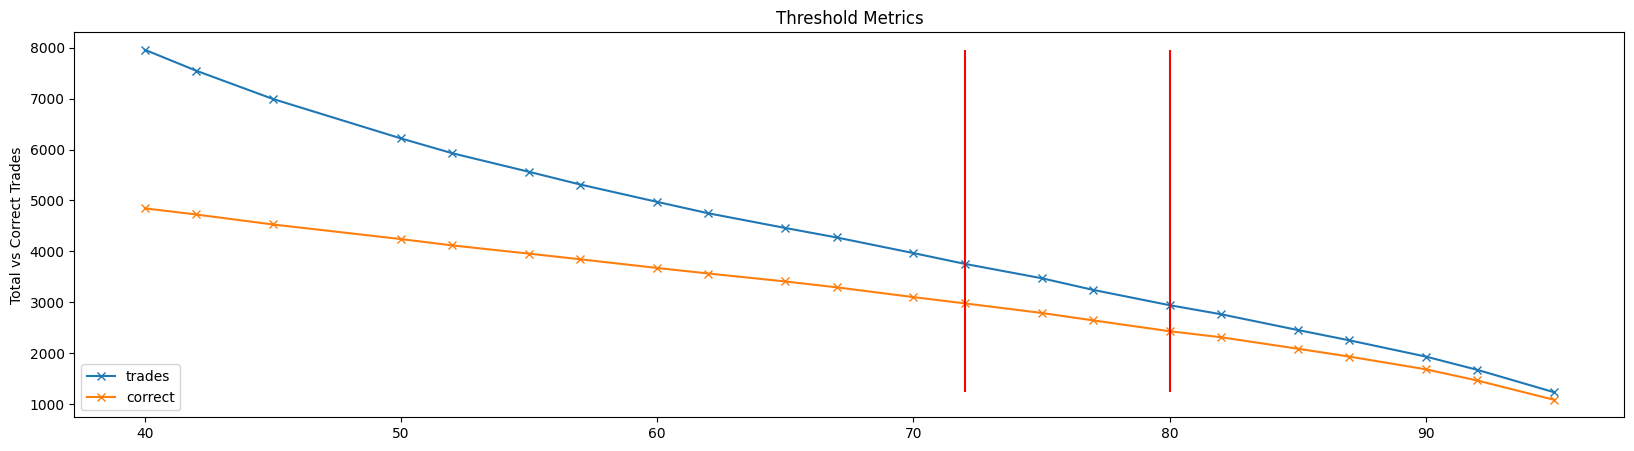

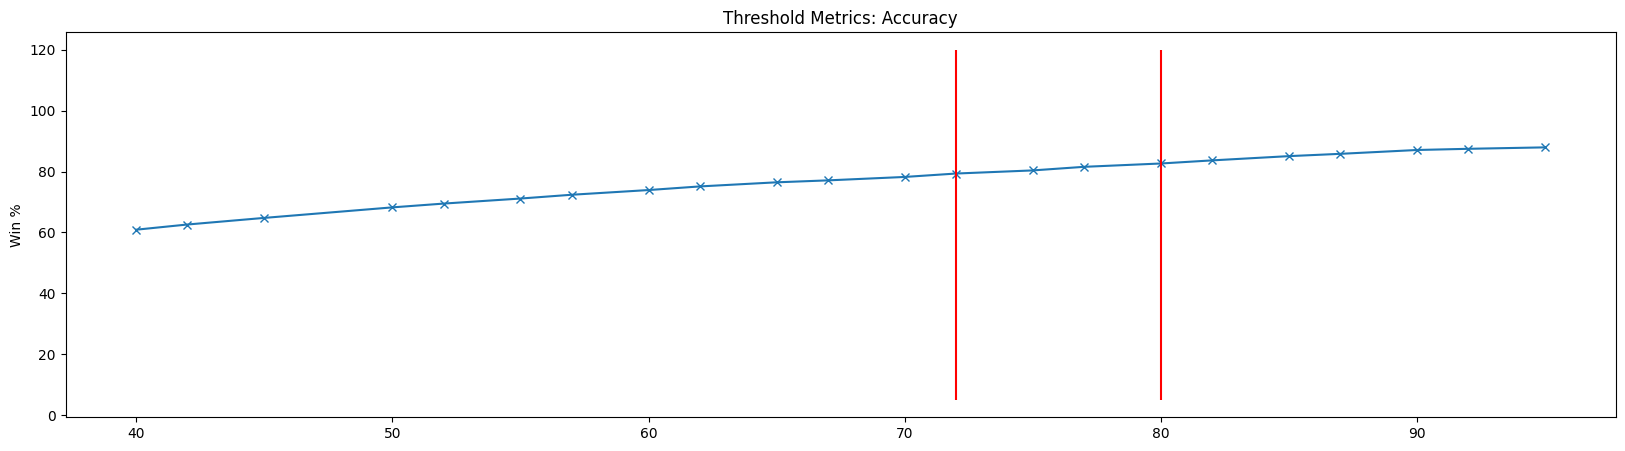

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,5))
plt.plot(metrics_df['threshold'], metrics_df[['trades','correct']], label=['trades','correct'], ls="solid", marker="x")
plt.gca().set(title='Threshold Metrics', ylabel='Total vs Correct Trades')
plt.vlines(x=[72,80], ymin=metrics_df['trades'].iloc[0], ymax=metrics_df['trades'].iloc[-1], colors=['red'])
plt.legend(loc='lower left')

plt.figure(figsize=(20,5))
plt.plot(metrics_df['threshold'], metrics_df['accuracy'], ls="solid", marker="x")
plt.gca().set(title='Threshold Metrics: Accuracy', ylabel='Win %')
plt.vlines(x=[72,80], ymin=5, ymax=120, colors=['red'])
#plt.legend(loc='lower left')
""

## Interval Returns

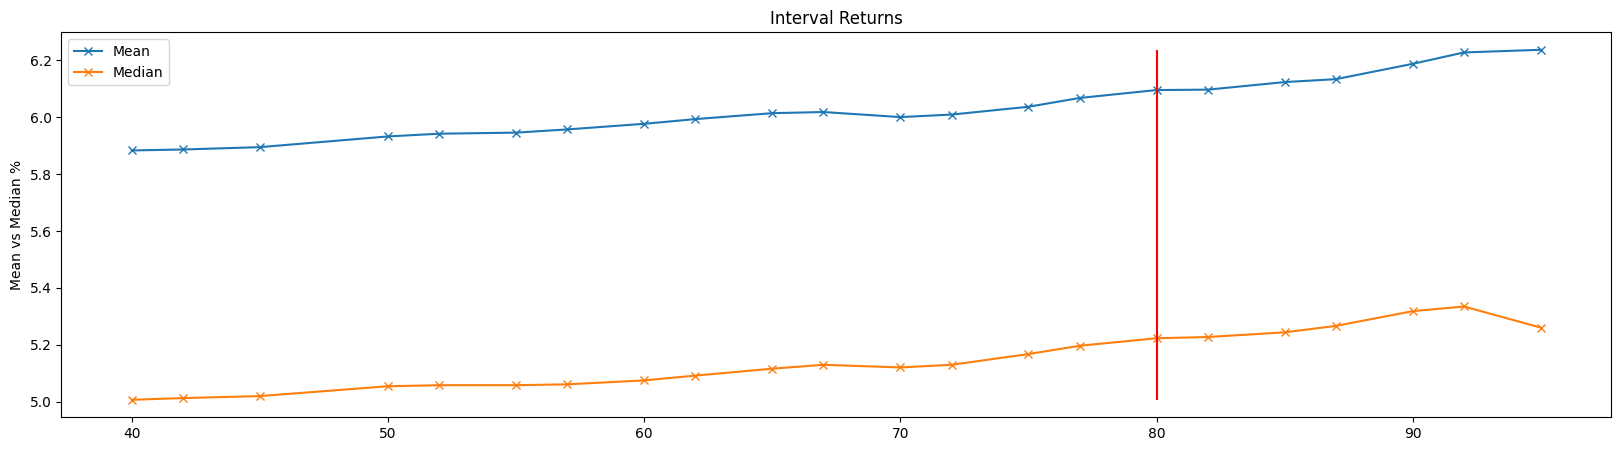

In [15]:
plt.figure(figsize=(20,5))
plt.plot(metrics_df['threshold'], metrics_df[['mean_return','median_return']], label=['Mean','Median'], ls="solid", marker="x")
plt.gca().set(title='Interval Returns', ylabel='Mean vs Median %')
plt.vlines(x=80, ymin=metrics_df['median_return'].min(), ymax=metrics_df['mean_return'].max(), colors=['red'])
plt.legend(loc='upper left')


## Interval Drawdowns

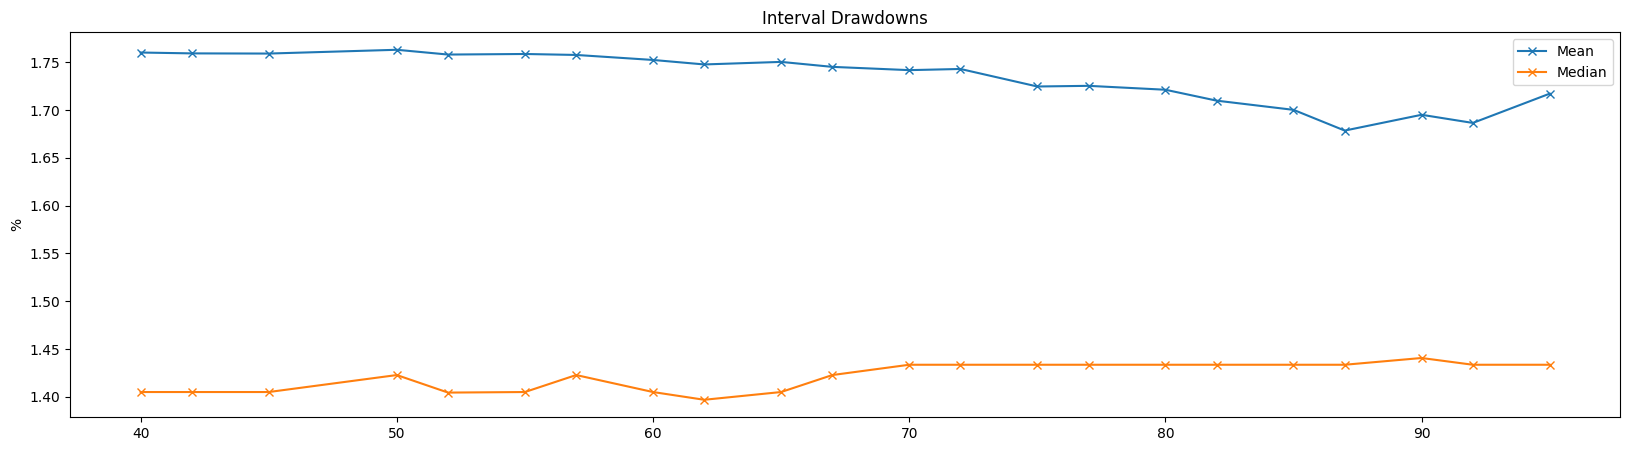

In [17]:
plt.figure(figsize=(20,5))
plt.plot(metrics_df['threshold'], metrics_df[['mean_drawdown','median_drawdown']], label=['Mean','Median'], ls="solid", marker="x")
plt.gca().set(title='Interval Drawdowns', ylabel='%')
plt.legend(loc='upper right')

### Total Returns

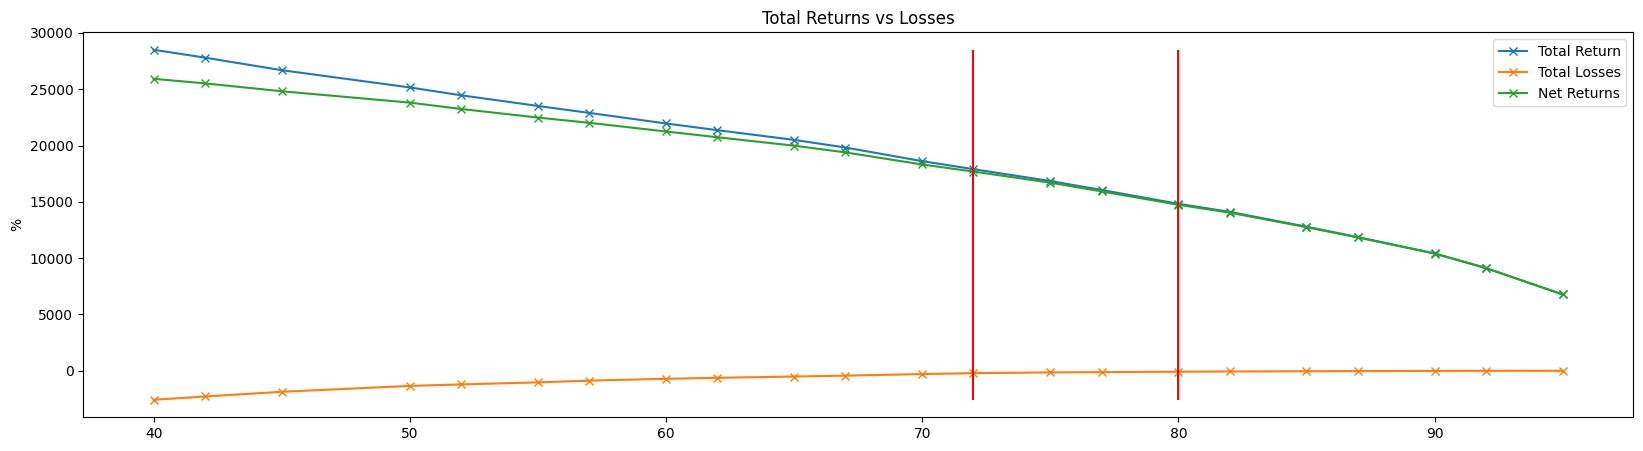

In [18]:
plt.figure(figsize=(20,5))
plt.plot(metrics_df['threshold'], metrics_df[['total_return', 'total_losses', 'net_returns']], label=["Total Return", "Total Losses", "Net Returns"], ls="solid", marker="x")
plt.vlines(x=[72,80], ymin=metrics_df['total_losses'].min(), ymax=metrics_df['total_return'].max(), colors=['red'])
plt.gca().set(title='Total Returns vs Losses', ylabel='%')
plt.legend(loc='upper right')

### Trade Duration

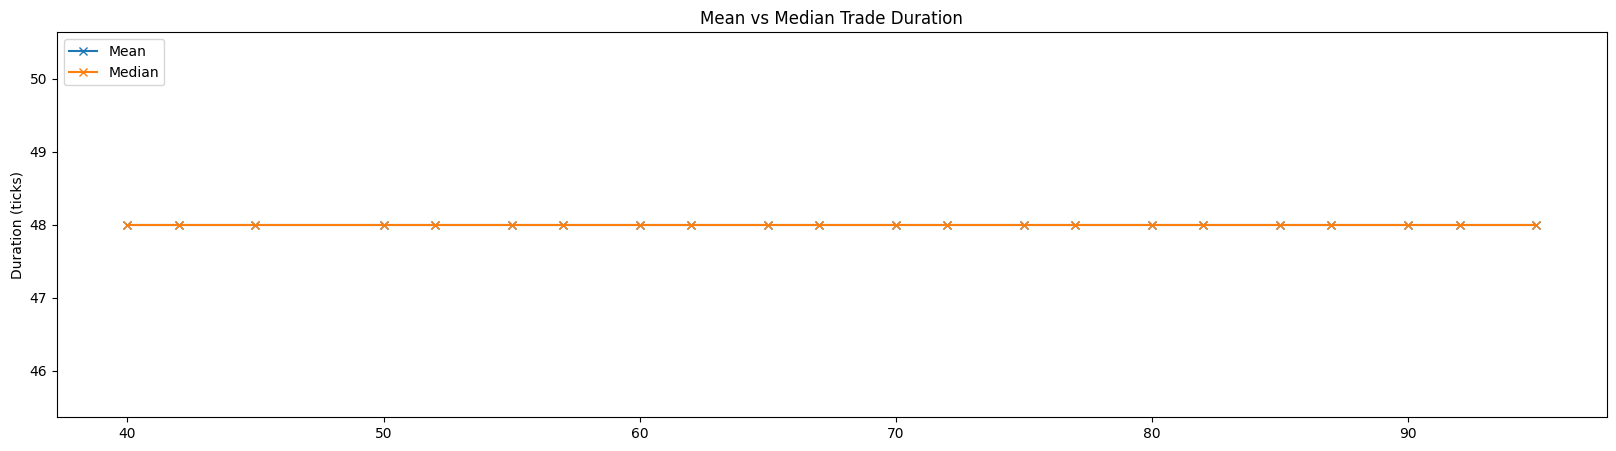

In [19]:
plt.figure(figsize=(20,5))
plt.plot(metrics_df['threshold'], metrics_df[['mean_duration', 'median_duration']], label=["Mean", "Median"], ls="solid", marker="x")
plt.gca().set(title='Mean vs Median Trade Duration', ylabel='Duration (ticks)')
plt.legend(loc='upper left')

# Running Performance

- Open Trade: BUY signal
- Close Trade: First SELL Signal
- Hold Trade: Consecutive BUY Signals
- Short Trade: Consecutive SELL Signals
- Stopped Trade: Trailing loss Triggered


In [20]:
combined_df = timesteps.join(df, how='right')
combined_df.head() 

,asset,c,v,hv,s14,s50,s100,s350,s700,delta,...,action_85,correct_85,action_87,correct_87,action_90,correct_90,action_92,correct_92,action_95,correct_95
start,,,,,,,,,,,,,,,,,,,,,
2021-01-01 17:00:00+00:00,Asset.btcusd,29303.0,61.901306,1402.951346,25312.412829,20392.972973,16381.633387,11269.162274,9513.588086,-0.000443,...,0,0,0,0,0,0,0,0,0,0
2021-01-01 17:30:00+00:00,Asset.btcusd,29109.0,894.071075,1396.391988,25321.860745,20398.450056,16385.514973,11270.367571,9514.349598,-0.006620,...,0,0,0,0,0,0,0,0,0,0
2021-01-01 18:00:00+00:00,Asset.btcusd,29049.0,296.135880,1389.393015,25331.180686,20403.886615,16389.389348,11271.569297,9515.109327,-0.002061,...,0,0,0,0,0,0,0,0,0,0
2021-01-01 18:30:00+00:00,Asset.btcusd,29106.0,889.242516,1383.477143,25340.576519,20409.302963,16393.280389,11272.772357,9515.870369,0.001962,...,0,0,0,0,0,0,0,0,0,0
2021-01-01 19:00:00+00:00,Asset.btcusd,29089.0,151.358527,1377.388014,25350.128602,20414.730463,16397.187473,11273.973512,9516.630653,-0.000584,...,0,0,0,0,0,0,0,0,0,0


In [85]:
updated_df = []

trade_on: bool = False
cumulative_delta: float = 0
cumulative_trailing_loss: float = 0

buy_probability = 0.40
#buy_probability = 0.70
#buy_probability = 0.60
action_buy = f'action_{int(100*buy_probability)}'
#sell_probability = 0.45
#sell_probability = 0.33
sell_probability = 0.20

#    row['trade_cumulative_delta'] = 0
#    row['trade_cumulative_trailing_loss'] = 0
#    row['trade_duration'] = 0

current_deltas = []
max_drawdown = 0
trailing_loss = 0

for idx, row in combined_df.iterrows():
    if trade_on:
        # Update the current trade value
        row['trade_on'] = True
        duration += 1
        current_deltas.append(row.delta)
        if row.delta < 0:
            trailing_loss = (1 + trailing_loss) * (1 + row.delta) - 1
            if trailing_loss < max_drawdown:
                max_drawdown = trailing_loss
        else:
            trailing_loss = 0
            
        # Check if to end current trade
        if row['probability'] <= sell_probability:
            # reset position for next trade
            trade_on = False
            row['trade_cumulative_delta'] = np.prod(np.array(current_deltas) + 1) - 1
            row['trade_cumulative_trailing_loss'] = max_drawdown
            row['trade_duration'] = len(current_deltas)
    else:
        row['trade_on'] = False
        if row[action_buy] == 1:
            # Detected a new trade
            trade_on = True
            cumulative_delta = 0
            cumulative_trailing_loss = 0
            current_deltas = []
            duration = 0
    # Accumulate
    updated_df.append(row)

updated_df = pd.DataFrame(updated_df)
updated_df.head()


,asset,c,v,hv,s14,s50,s100,s350,s700,delta,...,action_90,correct_90,action_92,correct_92,action_95,correct_95,trade_on,trade_cumulative_delta,trade_cumulative_trailing_loss,trade_duration
2021-01-01 17:00:00+00:00,Asset.btcusd,29303.0,61.901306,1402.951346,25312.412829,20392.972973,16381.633387,11269.162274,9513.588086,-0.000443,...,0,0,0,0,0,0,False,NaN,NaN,NaN
2021-01-01 17:30:00+00:00,Asset.btcusd,29109.0,894.071075,1396.391988,25321.860745,20398.450056,16385.514973,11270.367571,9514.349598,-0.006620,...,0,0,0,0,0,0,True,NaN,NaN,NaN
2021-01-01 18:00:00+00:00,Asset.btcusd,29049.0,296.135880,1389.393015,25331.180686,20403.886615,16389.389348,11271.569297,9515.109327,-0.002061,...,0,0,0,0,0,0,True,NaN,NaN,NaN
2021-01-01 18:30:00+00:00,Asset.btcusd,29106.0,889.242516,1383.477143,25340.576519,20409.302963,16393.280389,11272.772357,9515.870369,0.001962,...,0,0,0,0,0,0,True,NaN,NaN,NaN
2021-01-01 19:00:00+00:00,Asset.btcusd,29089.0,151.358527,1377.388014,25350.128602,20414.730463,16397.187473,11273.973512,9516.630653,-0.000584,...,0,0,0,0,0,0,True,NaN,NaN,NaN


In [86]:
trade_deltas = updated_df[updated_df['trade_cumulative_delta'].notna()]

trade_deltas['trade_cumulative_delta'].median(), trade_deltas['trade_cumulative_trailing_loss'].median()


(0.0057721908671108935, -0.1284238670457506)

In [87]:
len(updated_df[updated_df.trade_on]), len(updated_df)


(10731, 55540)

In [88]:
i = 0
trade_exits = []
prev_idx = updated_df[updated_df.trade_on].index[0]
interval_diff = 0
gain = 0
trailing_loss = 0
for idx, row in updated_df[updated_df.trade_on].iterrows():
    i += 1
    interval_diff = (idx - prev_idx).total_seconds()/1800
    print( idx, interval_diff )
    if interval_diff > 1:
        interval_diff = 0
        print(f"gain {gain:.3f}")
        trade_exits.append({
            'end': idx
            , 'gain': gain
            , 'trailing_loss': trailing_loss
        })
        gain = 0 
        trailing_loss = 0
    else:
        gain =  row.trade_cumulative_delta
        trailing_loss =  row.trade_cumulative_trailing_loss
    
    prev_idx = idx

if gain > 0:
    # Account for open position
    trade_exits.append({
        'end': idx
        , 'gain': gain
        , 'trailing_loss': trailing_loss
    })


2021-01-01 17:30:00+00:00 0.0
2021-01-01 18:00:00+00:00 1.0
2021-01-01 18:30:00+00:00 1.0
2021-01-01 19:00:00+00:00 1.0
2021-01-01 19:30:00+00:00 1.0
2021-01-01 20:00:00+00:00 1.0
2021-01-01 20:30:00+00:00 1.0
2021-01-01 21:00:00+00:00 1.0
2021-01-01 21:30:00+00:00 1.0
2021-01-01 22:00:00+00:00 1.0
2021-01-01 22:30:00+00:00 1.0
2021-01-01 23:00:00+00:00 1.0
2021-01-01 23:30:00+00:00 1.0
2021-01-02 00:00:00+00:00 1.0
2021-01-02 00:30:00+00:00 1.0
2021-01-02 01:00:00+00:00 1.0
2021-01-02 01:30:00+00:00 1.0
2021-01-02 02:00:00+00:00 1.0
2021-01-02 02:30:00+00:00 1.0
2021-01-02 03:00:00+00:00 1.0
2021-01-02 03:30:00+00:00 1.0
2021-01-02 04:00:00+00:00 1.0
2021-01-02 04:30:00+00:00 1.0
2021-01-02 05:00:00+00:00 1.0
2021-01-02 05:30:00+00:00 1.0
2021-01-02 06:00:00+00:00 1.0
2021-01-02 06:30:00+00:00 1.0
2021-01-02 07:00:00+00:00 1.0
2021-01-02 07:30:00+00:00 1.0
2021-01-02 08:00:00+00:00 1.0
2021-01-02 08:30:00+00:00 1.0
2021-01-02 09:00:00+00:00 1.0
2021-01-02 09:30:00+00:00 1.0
2021-01-02

In [89]:
trade_exits = pd.DataFrame(trade_exits)
trade_exits.head()


,end,gain,trailing_loss
0,2021-01-02 20:00:00+00:00,0.119988,-0.014051
1,2021-01-04 11:00:00+00:00,0.030000,-0.065818
2,2021-01-05 03:30:00+00:00,0.026270,-0.065818
3,2021-01-06 15:00:00+00:00,0.061650,-0.065818
4,2021-01-08 00:00:00+00:00,0.077380,-0.065818


In [90]:
trade_exits['gain'].mean(), trade_exits['gain'].median(), trade_exits['gain'].min(), trade_exits['gain'].max()

(0.013511906497960795,
 0.0057721908671108935,
 -0.11782483454193349,
 0.20638382236320352)

In [91]:
cumulative_gains = np.prod(trade_exits['gain'].to_numpy() + 1) - 1
cumulative_gains

321.623786816717

In [99]:
new_max_trailing_loss = 0.2
initial_account = 100000
account = initial_account
position_size = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.33, 0.35, 0.40, 0.45, 0.50, 1.00]
acct_gains = []
account_history = []
trade_date = []
for size in position_size:
    account = initial_account
    for idx, row in trade_exits.iterrows():
        if abs(row.trailing_loss) <= new_max_trailing_loss:
            position_profit = size*account * row.gain
            account =  account + position_profit
        if size == 0.20:
            account_history.append(account)
            trade_date.append(row.end)
    account_gain = 100 * (account - initial_account)/initial_account
    acct_gains.append(account_gain)
    print(f"Position size {size*100:3.0f}% Account Gain: {account_gain:6.2f}%")


Position size   5% Account Gain:  34.99%
Position size  10% Account Gain:  81.99%
Position size  15% Account Gain: 145.07%
Position size  20% Account Gain: 229.61%
Position size  25% Account Gain: 342.77%
Position size  30% Account Gain: 494.07%
Position size  33% Account Gain: 608.25%
Position size  35% Account Gain: 696.13%
Position size  40% Account Gain: 965.67%
Position size  45% Account Gain: 1324.80%
Position size  50% Account Gain: 1802.74%
Position size 100% Account Gain: 32162.38%


''

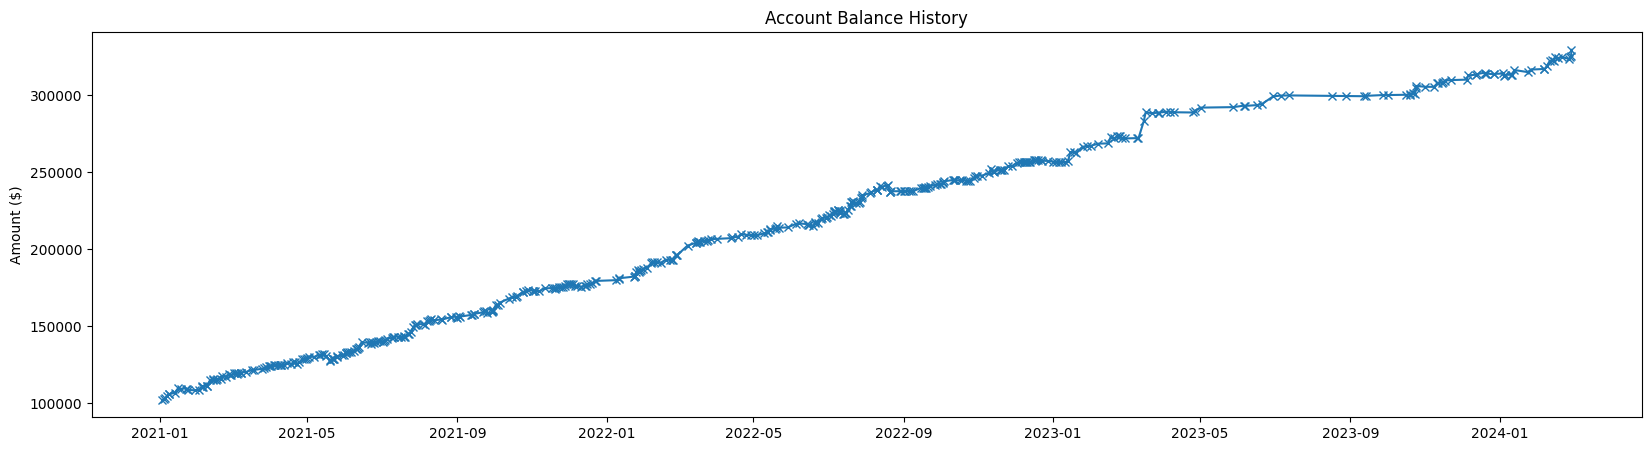

In [100]:
plt.figure(figsize=(20,5))
plt.plot(trade_date, account_history, ls="solid", marker="x")
plt.gca().set(title='Account Balance History', ylabel='Amount ($)')
''

### Price / Trade Execution

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


''

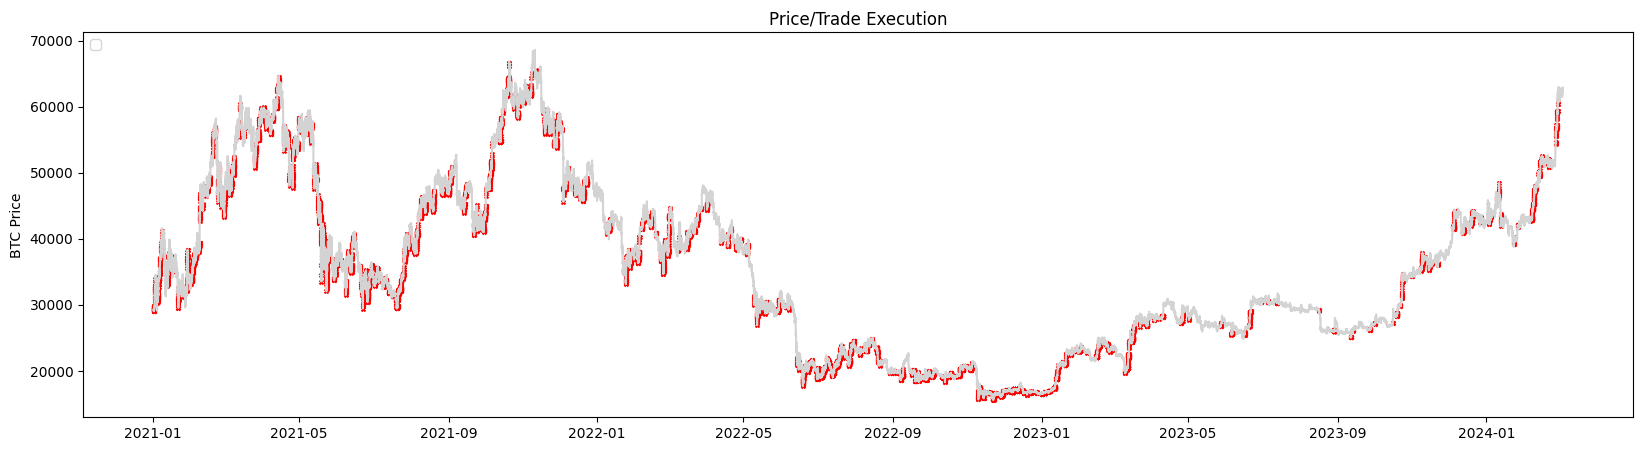

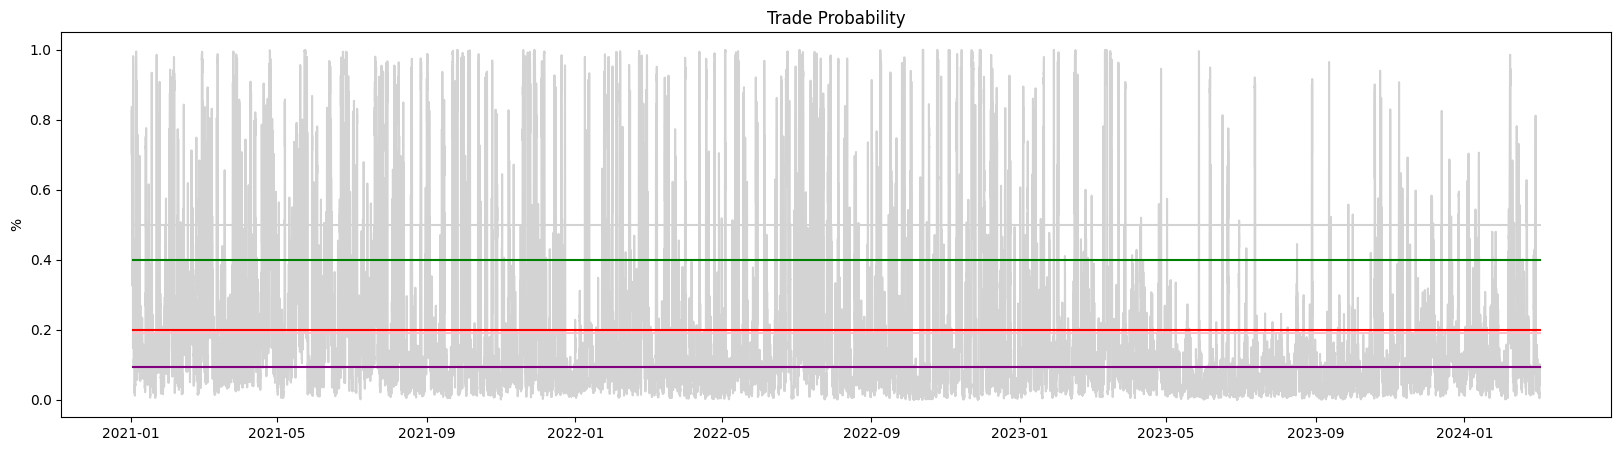

In [107]:
x = []
y = []
x = updated_df.index.to_numpy()
y = updated_df['c'].to_numpy()
color = updated_df['trade_on'].apply(lambda s: 'orange' if s else 'gray').to_numpy() 
area  = updated_df['trade_on'].apply(lambda s: 10 if s else 1).to_numpy()
x_markers = updated_df[updated_df.trade_on].index.to_numpy()
y_markers = updated_df[updated_df.trade_on]['c'].to_numpy()

plt.figure(figsize=(20,5))
plt.scatter(x_markers, y_markers, s=8, c='red', marker='x')
plt.plot(updated_df['c'], ls="solid", color='lightgray')
plt.gca().set(title='Price/Trade Execution', ylabel='BTC Price')
plt.legend(loc='upper left')

# Trade Probabilities
y = updated_df['probability'].to_numpy()
probability_mean = updated_df['probability'].mean()
probability_median = updated_df['probability'].median()
probability_std = updated_df['probability'].std()

plt.figure(figsize=(20,5))
plt.plot(x, y, color='lightgray')
plt.gca().set(title='Trade Probability', ylabel='%')
plt.hlines(y=sell_probability, xmin=x[0], xmax=x[-1], colors=['red'])
plt.hlines(y=0.50, xmin=x[0], xmax=x[-1], colors=['lightgray'])
plt.hlines(y=buy_probability, xmin=x[0], xmax=x[-1], colors=['green'])
plt.hlines(y=probability_mean, xmin=x[0], xmax=x[-1], colors=['pink'])
plt.hlines(y=probability_median, xmin=x[0], xmax=x[-1], colors=['purple'])

''

### Probabilities

In [108]:

print(f"Buy:    {buy_probability:11.3f}")
print(f"Sell:   {sell_probability:11.3f}")
print()
print(f"Mean:   {probability_mean:11.3f}")
print(f"Median: {probability_median:11.3f}")
print(f"Std:    {probability_std:11.3f}")
print()
print(f"66%:    {probability_mean+probability_std:11.3f}")
print(f"95%:    {probability_mean+(probability_std*2):11.3f}")

Buy:          0.400
Sell:         0.200

Mean:         0.192
Median:       0.094
Std:          0.238

66%:          0.429
95%:          0.667


### Range Analysis

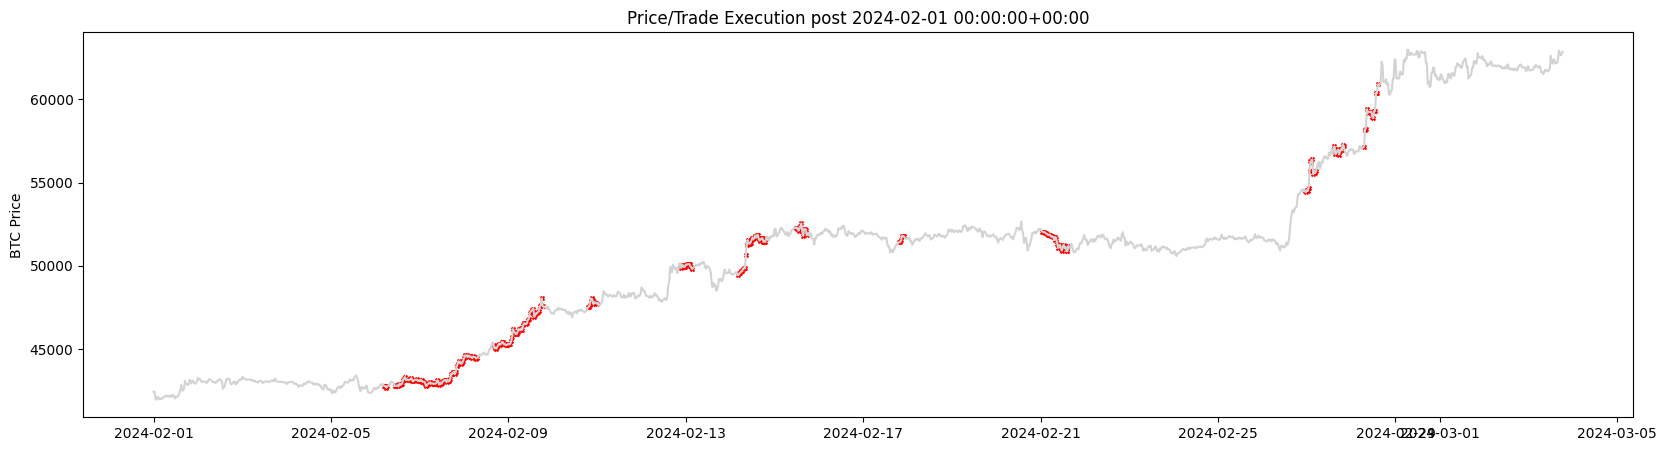

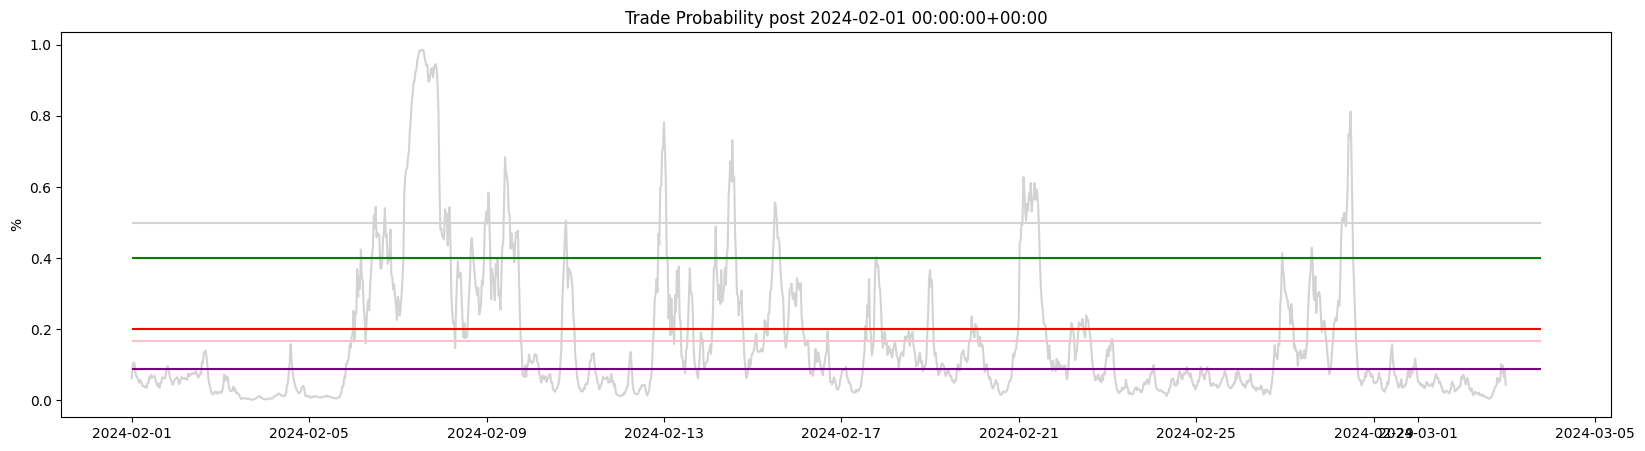

In [117]:
x = []
y = []
first_date = datetime(2024,2,1,0,0, tzinfo=timezone.utc)
df_slice = updated_df[updated_df.index >= first_date]
x = df_slice.index.to_numpy()
y = df_slice['c'].to_numpy()
color = df_slice['trade_on'].apply(lambda s: 'orange' if s else 'gray').to_numpy() 
area  = df_slice['trade_on'].apply(lambda s: 10 if s else 1).to_numpy()
x_markers = df_slice[df_slice.trade_on].index.to_numpy()
y_markers = df_slice[df_slice.trade_on]['c'].to_numpy()

plt.figure(figsize=(20,5))
plt.scatter(x_markers, y_markers, s=8, c='red', marker='x')
plt.plot(df_slice['c'], ls="solid", color='lightgray')
plt.gca().set(title=f'Price/Trade Execution post {first_date}', ylabel='BTC Price')

# Trade Probabilities
y = df_slice['probability'].to_numpy()
probability_mean = df_slice['probability'].mean()
probability_median = df_slice['probability'].median()
probability_std = df_slice['probability'].std()

plt.figure(figsize=(20,5))
plt.plot(x, y, color='lightgray')
plt.gca().set(title=f'Trade Probability post {first_date}', ylabel='%')
plt.hlines(y=sell_probability, xmin=x[0], xmax=x[-1], colors=['red'])
plt.hlines(y=0.50, xmin=x[0], xmax=x[-1], colors=['lightgray'])
plt.hlines(y=buy_probability, xmin=x[0], xmax=x[-1], colors=['green'])
plt.hlines(y=probability_mean, xmin=x[0], xmax=x[-1], colors=['pink'])
a = plt.hlines(y=probability_median, xmin=x[0], xmax=x[-1], colors=['purple'])


In [106]:
!pip freeze

absl-py==2.0.0
altair==5.2.0
annotated-types==0.6.0
ansi2html==1.9.1
anyio==3.7.1
APScheduler==3.10.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
astunparse==1.6.3
async-lru==2.0.4
attrs==23.1.0
Babel==2.13.1
beautifulsoup4==4.12.2
bleach==6.1.0
blinker==1.7.0
cachetools==5.3.2
certifi==2023.7.22
cffi==1.16.0
charset-normalizer==3.3.2
click==8.1.7
cloudpickle==3.0.0
comm==0.2.0
contourpy==1.2.0
cuda-python==12.3.0
cycler==0.12.1
dash==2.15.0
dash-core-components==2.0.0
dash-html-components==2.0.0
dash-table==5.0.0
dateparser==1.1.8
debugpy==1.8.0
decorator==5.1.1
defusedxml==0.7.1
distro==1.8.0
dm-reverb==0.13.0
dm-tree==0.1.8
executing==2.0.1
fastjsonschema==2.18.1
Flask==3.0.2
flatbuffers==23.5.26
fleet-context==1.0.16
fonttools==4.44.0
fqdn==1.5.1
gast==0.4.0
gin-config==0.5.0
gitdb==4.0.11
GitPython==3.1.42
google-auth==2.23.4
google-auth-oauthlib==1.0.0
google-pasta==0.2.0
greenlet==3.0.3
grpcio==1.59.2
gym==0.23.0
gym-notices==0.0.8
h11==0.14.0


In [109]:
updated_df.index[0]

Timestamp('2021-01-01 17:00:00+0000', tz='UTC')